# Computational Analysis of Gamelan Gong Kebyar Tuning for Regional Identification


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import helpers
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pickle
from rich import print

In [16]:
# Load and play audio file
audio_file_path = "audios/tj1.wav"
y, sr = librosa.load(audio_file_path)
print("Input audio:")
display(ipd.Audio(y, rate=sr))

Input audio:


## 1. Preprocessing


/tmp/ipykernel_245246/2619644576.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")


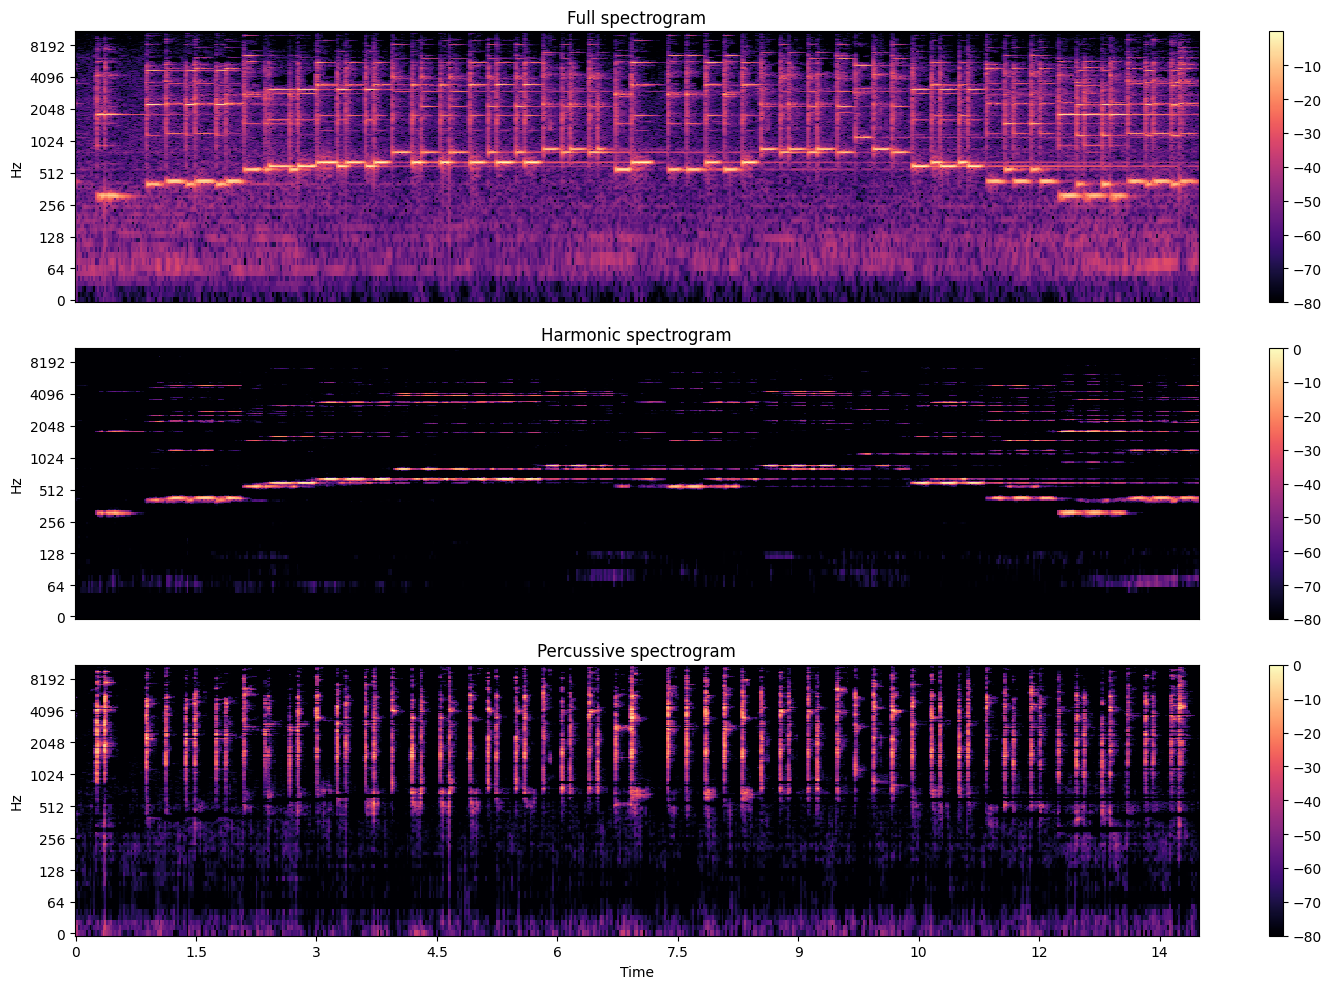

In [17]:
# compute stft and harmonic percussive separation
spectrogram = librosa.stft(y)
harmonic, percussive = librosa.decompose.hpss(spectrogram, margin=16, kernel_size=31)
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

plt.show()

## 2.1. Pitch Extraction


Text(0.5, 1.0, 'DSP: Parabolic interpolation Frequency')

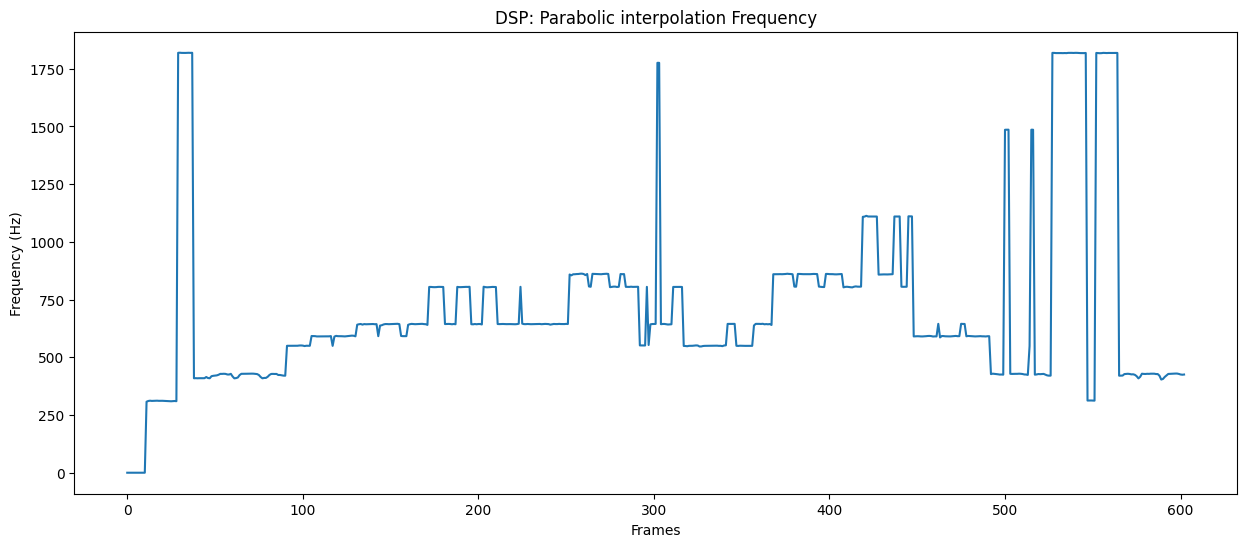

In [18]:
# Detect fundamental frequency and plot pitch countour
pitches_dsp = helpers.detect_pitch(S=harmonic, sr=sr, fmin=120, fmax=2000)

fig, ax = plt.subplots(figsize=(15, 6))
frames = np.arange(len(pitches_dsp))

ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("DSP: Parabolic interpolation Frequency")

## 2.2. Pitch segmentation


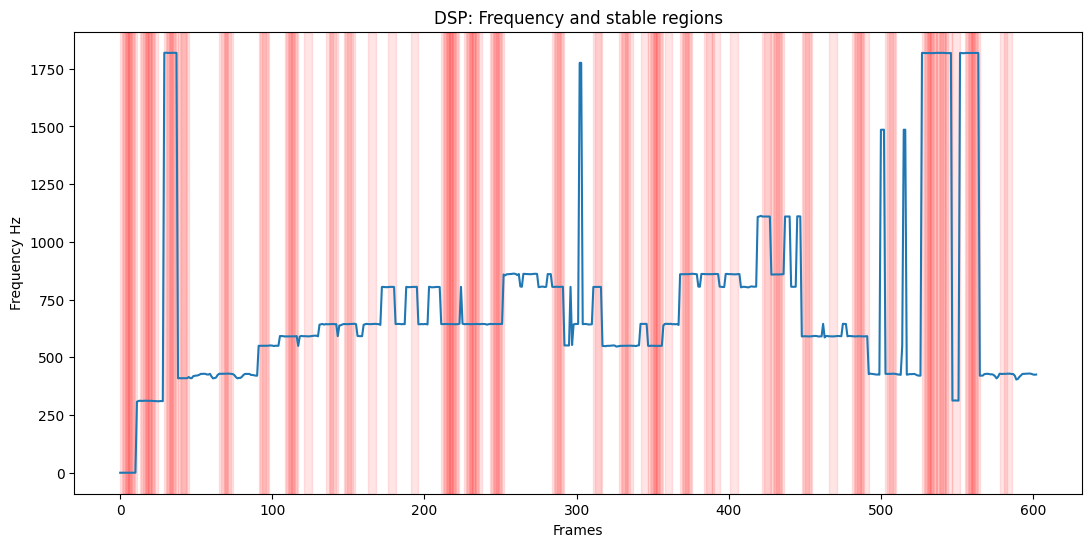

In [26]:
stable_regions, segments = helpers.find_stable_regions(frequencies=pitches_dsp, window_size=5, threshold=0.4)
fig, ax = plt.subplots(figsize=(13, 6))

# Plot the stable regions of pitch contour
ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency Hz")
ax.set_title("DSP: Frequency and stable regions")

for start, end in stable_regions:
    plt.axvspan(start, end, color="red", alpha=0.1)

plt.show()

## 3. Tone identification


In [20]:
# Group together dectected frequencies that are close to each other less than 10hz
tone_group = helpers.group_and_average_frequencies(segments)

# Sanity check, play estimated tones
wait_time = 0.5
audio = np.array([])
for tone in tone_group:
    tone_audio = librosa.tone(tone, duration=1)
    wait_audio = np.zeros(int(wait_time * sr))
    audio = np.concatenate((audio, tone_audio, wait_audio))

print("Playing concatenated audio:")
display(ipd.Audio(audio, rate=sr))

Playing concatenated audio:


In [21]:
# Given the extracted and grouped tones, it finds the scale.
# It returns the interval in cents bewtween low-ding to hi-ding.
scale_distances = helpers.find_scale(tone_group)

Ding: 549.7723106971154
Dong: 590.9153401692708
Deng: 643.9472403690733
Dung: 805.0412445068359
Dang: 859.7108306884766
Hi-ding: 1109.9400024414062
Scale distances: [124.94 148.79 386.54 113.75 442.27]


## 4.1 Tuning characterization


In [22]:
begbeg = np.array([120, 114, 432, 81, 453])
sedang = np.array([136, 155, 379, 134, 396])
tirus = np.array([197, 180, 347, 104, 372])

similarity = cosine_similarity([scale_distances], [begbeg, sedang, tirus])[0]
max_similarity = np.max(similarity)
print(f"Cosine similarity to begbeg: {similarity[0]}{' *winner*' if similarity[0] == max_similarity else ''}")
print(f"Cosine similarity to sedang: {similarity[1]}{' *winner*' if similarity[1] == max_similarity else ''}")
print(f"Cosine similarity to tirus: {similarity[2]}{' *winner*' if similarity[2] == max_similarity else ''}")
print("-------")

eucl_distances = euclidean_distances(X=[scale_distances], Y=[begbeg, sedang, tirus])[0]
min_distance = np.min(eucl_distances)
print(
    f"Euclidian distance to begbeg: {eucl_distances[0]}{' *winner*' if eucl_distances[0] == min_distance else ''}"
)
print(
    f"Euclidian distance to sedang: {eucl_distances[1]}{' *winner*' if eucl_distances[1] == min_distance else ''}"
)
print(
    f"Euclidian distance to tirus: {eucl_distances[2]}{' *winner*' if eucl_distances[2] == min_distance else ''}"
)

Cosine similarity to begbeg: 0.9952031685938864
Cosine similarity to sedang: 0.9973943903764346 *winner*
Cosine similarity to tirus: 0.9854110746183501
-------
Euclidian distance to begbeg: 67.0004082077124
Euclidian distance to sedang: 52.618577517831206 *winner*
Euclidian distance to tirus: 112.97369029999851


## 4.2. Regency classification


In [23]:
dataset_df = pickle.load(open("pickles/dataset.pkl", "rb"))
dataset_df

/tmp/ipykernel_245246/3233622081.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  dataset_df = pickle.load(open("pickles/dataset.pkl", "rb"))


,Region,Gamelan,Flavor,ding3,dong3,deng3,dung3,dang3,ding4
0,Gianyar,Sumampan,-,553.1,595.2,644.6,810.7,873.4,1115.2
1,Gianyar,Sumampan,-,554.4,597.9,647.2,813.5,880.0,1117.1
2,Gianyar,Sumampan,+,561.5,603.1,652.1,818.2,883.1,1124.9
3,Gianyar,Sumampan,+,561.5,603.1,652.1,818.2,883.1,1124.9
4,Gianyar,Sumampan,-,553.1,595.2,644.6,810.7,873.4,1115.2
...,...,...,...,...,...,...,...,...,...
309,Bangli,Blungbang Bangli,+,484.3,533.0,582.9,738.7,848.1,992.3
310,Bangli,Blungbang Bangli,+,482.9,532.4,585.0,732.8,848.6,993.5
311,Bangli,Blungbang Bangli,+,484.3,533.0,582.9,738.7,848.1,992.3
312,Bangli,Blungbang Bangli,-,479.0,531.5,574.9,726.4,807.9,986.1


In [24]:
# Compute all Pemade distances
all_scales = dataset_df.iloc[:, 3:9].values
all_distances = []
for scale in all_scales:
    dist = []
    for i in range(len(scale) - 1):
        tone_a = scale[i]
        tone_b = scale[i + 1]
        d = helpers.compute_distance(tone_a, tone_b)
        # print(f"Distance between {tone_a} and {tone_b}: {d} cents")
        dist.append(d)
    all_distances.append(dist)

similarities = []
max_similarity = 0
max_similarity_index = 0

euc_distances = []
min_distance = np.Infinity
min_distance_index = 0

# Compare the input tone distances with all pemade tunings in the dataset
for i, distance in enumerate(all_distances):
    # cosine similarity
    similarity = cosine_similarity([distance], [scale_distances])[0][0]
    similarities.append(similarity)
    if similarity > max_similarity:
        max_similarity = similarity
        max_similarity_index = i

    # euclidean distance
    euc_distance = euclidean_distances([scale_distances], [distance])[0][0]
    euc_distances.append(euc_distance)
    if euc_distance < min_distance:
        min_distance = euc_distance
        min_distance_index = i

print("--- Cosine similarity ---")
print(f"Max similarity: {max_similarity} at index {max_similarity_index}")
print(dataset_df.iloc[max_similarity_index])

print("--- Euclidean distance ---")
print(f"Min distance: {min_distance} at index {min_distance_index}")
print(dataset_df.iloc[min_distance_index])

--- Cosine similarity ---
Max similarity: 0.9995531387474885 at index 193
Region     Badung
Gamelan     Kokar
Flavor          +
ding3       589.4
dong3       632.8
deng3       694.0
dung3       863.9
dang3       926.4
ding4      1184.9
Name: 193, dtype: object
--- Euclidean distance ---
Min distance: 22.238570648485386 at index 193
Region     Badung
Gamelan     Kokar
Flavor          +
ding3       589.4
dong3       632.8
deng3       694.0
dung3       863.9
dang3       926.4
ding4      1184.9
Name: 193, dtype: object
